# Setup

Collab specific stuff:

In [29]:
running_colab = False

In [30]:
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    logs_directory = 'drive/MyDrive/summaries'
    !pip install -r "drive/MyDrive/requirements.txt"
else:
    logs_directory = 'summaries'

Imports

In [31]:
import time
import gym_2048
from tensorforce import Agent, Environment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Functions

# Useful code snippets

Render "beautiful" 2048 grid:

`imshow(environment._environment.environment.render(mode="rgb_array"))`

Illegal move reward:

`environment._environment.environment.set_illegal_move_reward(-10)`

Log2 reward:

`log2_reward = reward if reward <= 0 else np.log2(reward)`

Show TensorBoard graphs:

`%tensorboard --logdir summaries` (with parameter `summarizer=dict(directory='summaries')` in the `Agent.create()` method)

# Hyperparams to test

`exploration`

`learning_rate`

Negative reward for illegal moves: `environment._environment.environment.set_illegal_move_reward(-1)`

`target_sync_frequency`

`batch_size` & `update_frequency`

Constant reward / Log reward

# Custom hyper params train

Modified hyperparams :

Ex: `learning_rate = 0.01` et `batch_size = 32`

In [33]:
def train_agent(params, print_freq, file_name):
    ''' Function creating environment & agent based on params dict. 
    num_episodes defines how many episodes agent will train & print_freq defines 
    printing frequency. 
    Function will create dict of metrics & dict of params used in function & both
    will be saved as a csv with file_name'''

    # create a 2048 environment
    environment = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
        , max_episode_timesteps = params['max_episode_timesteps']
    )

    # create an agent
    agent = Agent.create(
        agent = 'dqn'
        , environment = environment
        , **params['agent_hyperparams']
        , summarizer = dict(directory=logs_directory
                            , summaries=[
                                "regularization-loss"
                                , "loss"
                                , "episode-length"
                                , "episode-reward"
                                , "objective-loss"
                                , "reward"
                                , "update-return"
                            ]
                           )
    )

    # instantiate lists to record global training metrics
    max_tiles = []
    scores = []
    updates = []
    valid_moves = []
    run_time = []
    start_training_time = time.time()

    for episode in range(params['num_episodes']):
        state = environment.reset()
        terminal = False

        #Checking metrics while training
        state_freeze = state.copy()
        num_updates = 0
        num_moves = 0
        invalid_moves = 0
        start_episode_time = time.time()

        while not terminal:
            #Core
            action = agent.act(states=dict(state=state,  action_mask=environment._environment.environment.get_invalid_moves()))
            state, terminal, reward = environment.execute(actions=action)
            log2_reward = reward if reward <= 0 else np.log2(reward)
            num_updates += agent.observe(terminal=terminal, reward=log2_reward)

            #Number of moves
            num_moves += 1

            #Number of invalid moves
            if (state == state_freeze).all():
                invalid_moves += 1
            state_freeze = state.copy()

        # Storing score and max tile
        max_tiles.append(environment._environment.environment.Matrix.max())
        scores.append(environment._environment.environment.score)
        updates.append(num_updates)
        valid_moves.append(num_moves)
        run_time.append(round(time.time() - start_episode_time,2))

        if episode % print_freq == 0:
            print('Episode {}: score = {}, terminal = {}, updates={}, max_tile={}, valid_moves={}, invalid_moves={}, seconds={}'\
                  .format(episode, environment._environment.environment.score , terminal, num_updates, max_tiles[-1], num_moves-invalid_moves, invalid_moves, round(time.time() - start_episode_time,2)))
        
    metrics_dict = {
        'max_tiles': max_tiles
        , 'scores': scores
        , 'updates': updates
        , 'valid_moves': valid_moves
        , 'run_time' : run_time
    }
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_path = f'training_runs/{file_name}_metrics.csv'
    metrics_df.to_csv(metrics_path)
    
    params_path = f'training_runs/{file_name}_params.json'
    with open(params_path, 'w') as fp:
        json.dump(params, fp)
    
    environment.close()
    
    return (metrics_df, params, agent)

In [34]:
agent_hyperparams_dict = {
    'max_episode_timesteps': 1000 # Maximum steps allowed in episode. This hyper-param is for environment
    , 'batch_size': 16
    , 'update_frequency': 4
    , 'learning_rate': 0.001
    , 'discount': 0.8
    , 'memory': 30000
    , 'exploration': 0.1
    , 'target_sync_frequency': 4
    , 'horizon': 2
}

input_dict = {
    'max_episode_timesteps': 1000
    , 'num_episodes': 3000
    , 'agent_hyperparams': agent_hyperparams_dict
}

In [28]:
test_df = train_agent(input_dict, 1, 'test')

Episode 0: score = 2016.0, terminal = 1, updates=9, max_tile=256, valid_moves=162, invalid_moves=0, seconds=4.81
Episode 1: score = 2372.0, terminal = 1, updates=12, max_tile=256, valid_moves=201, invalid_moves=0, seconds=0.93
Episode 2: score = 2252.0, terminal = 1, updates=13, max_tile=128, valid_moves=211, invalid_moves=0, seconds=0.96
Episode 3: score = 1132.0, terminal = 1, updates=7, max_tile=128, valid_moves=122, invalid_moves=0, seconds=0.54
Episode 4: score = 1400.0, terminal = 1, updates=9, max_tile=128, valid_moves=147, invalid_moves=0, seconds=0.71
Episode 5: score = 1024.0, terminal = 1, updates=6, max_tile=128, valid_moves=109, invalid_moves=0, seconds=0.49
Episode 6: score = 2880.0, terminal = 1, updates=14, max_tile=256, valid_moves=233, invalid_moves=0, seconds=1.07
Episode 7: score = 728.0, terminal = 1, updates=5, max_tile=64, valid_moves=91, invalid_moves=0, seconds=0.47
Episode 8: score = 1836.0, terminal = 1, updates=11, max_tile=128, valid_moves=187, invalid_move

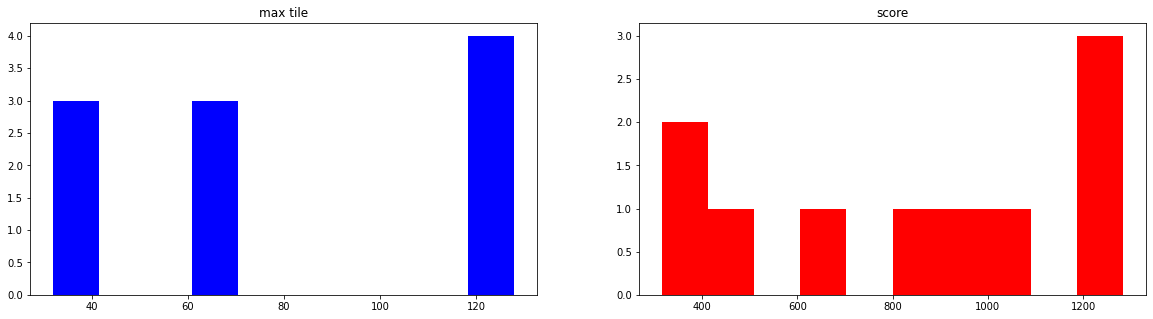

In [26]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(test_df[0].max_tiles, color = 'b')
ax1.set_title('max tile')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(test_df[0].scores, color = 'r')
ax2.set_title('score');

In [8]:
%tensorboard --logdir $logs_directory

# Default hyper params

In [ ]:
#environment = Environment.create(
#    environment='gym', level='2048-v0', max_episode_timesteps=1000
#)

# Defaut hyperparams
#agent = Agent.create(
#    agent='dqn',
#    batch_size=16, # Required by Tensorforce
#    update_frequency=4, # Update frequency, TensorForce default : batch_size * 0.25
#    learning_rate = 0.001, # (TensorForce default)
#    discount = 0.99, # (TensorForce default)
#    memory=10000,
#    exploration=0.1, # (0 is the TensorForce default)
#    target_sync_frequency=4, # (1 is the TensorForce default)
#)
#
#for episode in range(1000):
#    train...
#    log2_reward = reward if reward <= 0 else np.log2(reward)